# 0.0 Imports

In [1]:
import warnings

import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap

from sklearn.manifold    import TSNE
from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from plotly     import express as px
from sklearn    import cluster as c
from sklearn    import ensemble as en
from sklearn    import decomposition as dd
from sklearn    import metrics as mt
from sklearn    import preprocessing as pp
from matplotlib import pyplot as plt

# 0.1 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

# 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('C:/Users/PICHAU/repos/cluster_project/data/raw/data.csv', encoding = 'unicode_escape') 

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
df1.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 1.1 Data Dimensions and Types

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## 1.2 Check NaN's

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 1.2.1 Replace NaN's

In [8]:
df_missing = df1.loc[df1['CustomerID'].isna(), :]
df_not_missing = df1.loc[~df1['CustomerID'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame( df_missing['InvoiceNo'].drop_duplicates())
df_backup['CustomerID'] = np.arange(19000, 19000+len( df_backup ), 1)

# merging
df1 = pd.merge(df1, df_backup, on='InvoiceNo', how='left')

# coalesce 
df1['CustomerID'] = df1['CustomerID_x'].combine_first(df1['CustomerID_y'])

# drop extra columns
df1 = df1.drop(columns=['CustomerID_x', 'CustomerID_y'], axis=1)

In [10]:
df1.isna().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
Country           0
CustomerID        0
dtype: int64

## 1.3 Change Types

In [11]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df1['CustomerID'] = df1['CustomerID'].astype('int64')

In [12]:
df1.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850


## 1.3 Descriptive Statistics

## 1.3.1 Numerical Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,UnitPrice,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,CustomerID,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


<b>INVESTIGATING</b>:

== Quantity values of max and min;

== UnitPrice min as negative.

In [14]:
x = df1[(df1['Quantity']<0)]
print('Number of rows that Quantity is negative: ', len(x))

Number of rows that Quantity is negative:  10624


## 1.3.2 Categorical Statistics

In [15]:
cat_att = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [16]:
# invoice number
x = cat_att[(cat_att['InvoiceNo'].str.contains('[^0-9]+', regex=True))]
x1 = df1[(df1['Quantity']<0)]
print('Number of rows that invoice number has C: ', len(x))

Number of rows that invoice number has C:  9291


In [17]:
# stock
x

y = cat_att[(cat_att['StockCode'].str.contains('^[a-zA-Z\s]+$', regex=True))]
y['StockCode'].unique()

array(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 'm',
       'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [18]:
# Description

In [19]:
# Country
x = df1[['CustomerID', 'Country']].drop_duplicates().groupby('Country').count().reset_index()
x

,Country,CustomerID
0,Australia,9
1,Austria,11
2,Bahrain,4
3,Belgium,25
4,Brazil,1
5,Canada,4
6,Channel Islands,9
7,Cyprus,8
8,Czech Republic,1
9,Denmark,9


# 2.0 Data Filtration

In [20]:
df2 = df1.copy()

In [21]:
 # Numerical attribute 
df2 = df2[(df2['UnitPrice'] >= 0.04)]

# Categorical attributes
df2 = df2[~df2['StockCode'].isin(['POST', 'D', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE', 
                                  'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])
         ]

# --- Description
df2 = df2.drop(columns='Description', axis=1)

# --- Country 
df2 = df2[~df2['Country'].isin(['European Community', 'Unspecified'])]

# --- Bad Users
df2 = df2[~df2['CustomerID'].isin([16446, 12346])]

# --- Quantity
df2_return = df2[(df1['Quantity'] < 0)]
df2_purchase = df2[(df1['Quantity'] >= 0)]

# 3.0 Feature Engineering

In [22]:
df3 = df2.copy()

## 3.1 Feature Creation

In [23]:
# refference table - customer
df_ref = pd.DataFrame(df3['CustomerID']).drop_duplicates(keep='first', ignore_index=True)
df_ref = df_ref.dropna(subset=['CustomerID'])

# Gross Revenue (Monetary)
df2_purchase['GrossRevenue'] = df2_purchase['Quantity'] * df2_purchase['UnitPrice']

df_monetary = df2_purchase[['GrossRevenue','CustomerID']].groupby('CustomerID').sum().reset_index() 
df_ref = pd.merge(df_ref, df_monetary, on='CustomerID', how='left')

# Recency days (Recency)
df_recency = df2_purchase[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max().reset_index()
df_recency['RecencyDays'] = (df2_purchase['InvoiceDate'].max() - df_recency['InvoiceDate']).dt.days
df_recency = df_recency[['CustomerID', 'RecencyDays']]
df_ref = pd.merge(df_ref, df_recency, on='CustomerID', how='left')

# Purchase number (Frequency) 
df_freq = df2_purchase[['CustomerID', 'InvoiceNo']].groupby('CustomerID').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='CustomerID', how='left')

# Average Ticket
df_avgt = df2_purchase[['CustomerID', 'GrossRevenue']].groupby('CustomerID').mean().reset_index().rename(columns={'GrossRevenue':'AvgTicket'})
df_ref = pd.merge(df_ref, df_avgt, on='CustomerID', how='left')

# Average recency days
df_aux = df2[['CustomerID', 'InvoiceDate']].drop_duplicates().sort_values(['CustomerID', 'InvoiceDate'], ascending=['False', 'False'])
df_aux['NextCustomerID'] = df_aux['CustomerID'].shift() # next customer
df_aux['PreviousDate'] = df_aux['InvoiceDate'].shift() # next invoince date

df_aux['AvgRecencyDays'] = df_aux.apply(lambda x: (x['InvoiceDate'] - x['PreviousDate']).days if x['CustomerID'] == x['NextCustomerID'] else np.nan, axis=1)

df_aux = df_aux.drop( ['InvoiceDate', 'NextCustomerID', 'PreviousDate'], axis=1 ).dropna()

df_avg_recency_days = df_aux.groupby('CustomerID').mean().reset_index()

df_ref = pd.merge(df_ref, df_avg_recency_days, on='CustomerID', how='left')

# Products Quantity
df_freq = (df2_purchase.loc[:, ['CustomerID', 'Quantity']].groupby( 'CustomerID' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'Quantity': 'QtItems'} ) )
df_ref = pd.merge( df_ref, df_freq, on='CustomerID', how='left' )
df_ref.isna().sum()

# Distinct Products purchased
df_freq2 = (df2_purchase.loc[:, ['CustomerID', 'StockCode']].groupby('CustomerID').count().reset_index().rename(columns={'StockCode': 'QuantityProducts'}))
df_ref = pd.merge(df_ref, df_freq2, on='CustomerID', how='left')

# Frequency
df_aux1 = (df2_purchase[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()
                                                             .groupby('CustomerID')
                                                             .agg( max_ = ('InvoiceDate', 'max' ), 
                                                                   min_ = ('InvoiceDate', 'min' ),
                                                                   days_= ('InvoiceDate', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ('InvoiceNo', 'count' ) ) ).reset_index()

df_aux1['Frequency'] = df_aux1[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )
df_ref = pd.merge(df_ref, df_aux1[['CustomerID', 'Frequency']], on='CustomerID', how='left')

# Number of Returns
df_return = df2_return[['CustomerID', 'Quantity']].groupby( 'CustomerID' ).sum().reset_index().rename( columns={'Quantity':'QtReturns'} )
df_return['QtReturns'] = df_return['QtReturns'] * -1

df_ref = pd.merge( df_ref, df_return, how='left', on='CustomerID' )
df_ref.loc[df_ref['QtReturns'].isna(), 'QtReturns'] = 0

# Basket Size
df_aux2 = (df2_purchase.loc[:, ['CustomerID', 'InvoiceNo', 'Quantity']].groupby('CustomerID')
                                                                            .agg(n_purchase=('InvoiceNo', 'nunique'),
                                                                                 n_products=('Quantity', 'sum'))
                                                                            .reset_index())

df_aux2['AvgBasketSize'] = df_aux2['n_products'] / df_aux2['n_purchase']
df_ref = pd.merge(df_ref, df_aux2[['CustomerID', 'AvgBasketSize']], how='left', on='CustomerID' )

#Basket size - distinct products
df_aux3 = (df2_purchase.loc[:, ['CustomerID', 'InvoiceNo', 'StockCode']].groupby('CustomerID')
                                                                            .agg(n_purchase=('InvoiceNo', 'nunique'),
                                                                                 n_products=('StockCode', 'nunique' ) )
                                                                            .reset_index() )

df_aux3['AvgUniqueBasketSize'] = df_aux3['n_products'] / df_aux3['n_purchase']
df_ref = pd.merge(df_ref, df_aux3[['CustomerID', 'AvgUniqueBasketSize']], how='left', on='CustomerID')


In [24]:
df_ref.isna().sum()

CustomerID                0
GrossRevenue             67
RecencyDays              67
InvoiceNo                67
AvgTicket                67
AvgRecencyDays         2721
QtItems                  67
QuantityProducts         67
Frequency                67
QtReturns                 0
AvgBasketSize            67
AvgUniqueBasketSize      67
dtype: int64

# 4.0 EDA

In [25]:
df4 = df_ref.dropna()
df4.isna().sum()

CustomerID             0
GrossRevenue           0
RecencyDays            0
InvoiceNo              0
AvgTicket              0
AvgRecencyDays         0
QtItems                0
QuantityProducts       0
Frequency              0
QtReturns              0
AvgBasketSize          0
AvgUniqueBasketSize    0
dtype: int64

In [26]:
univ = ProfileReport(df4)
#univ.to_file('univ_output2.html')

## 4.2 Bivariate Analysis

In [27]:
cols = ['CustomerID']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

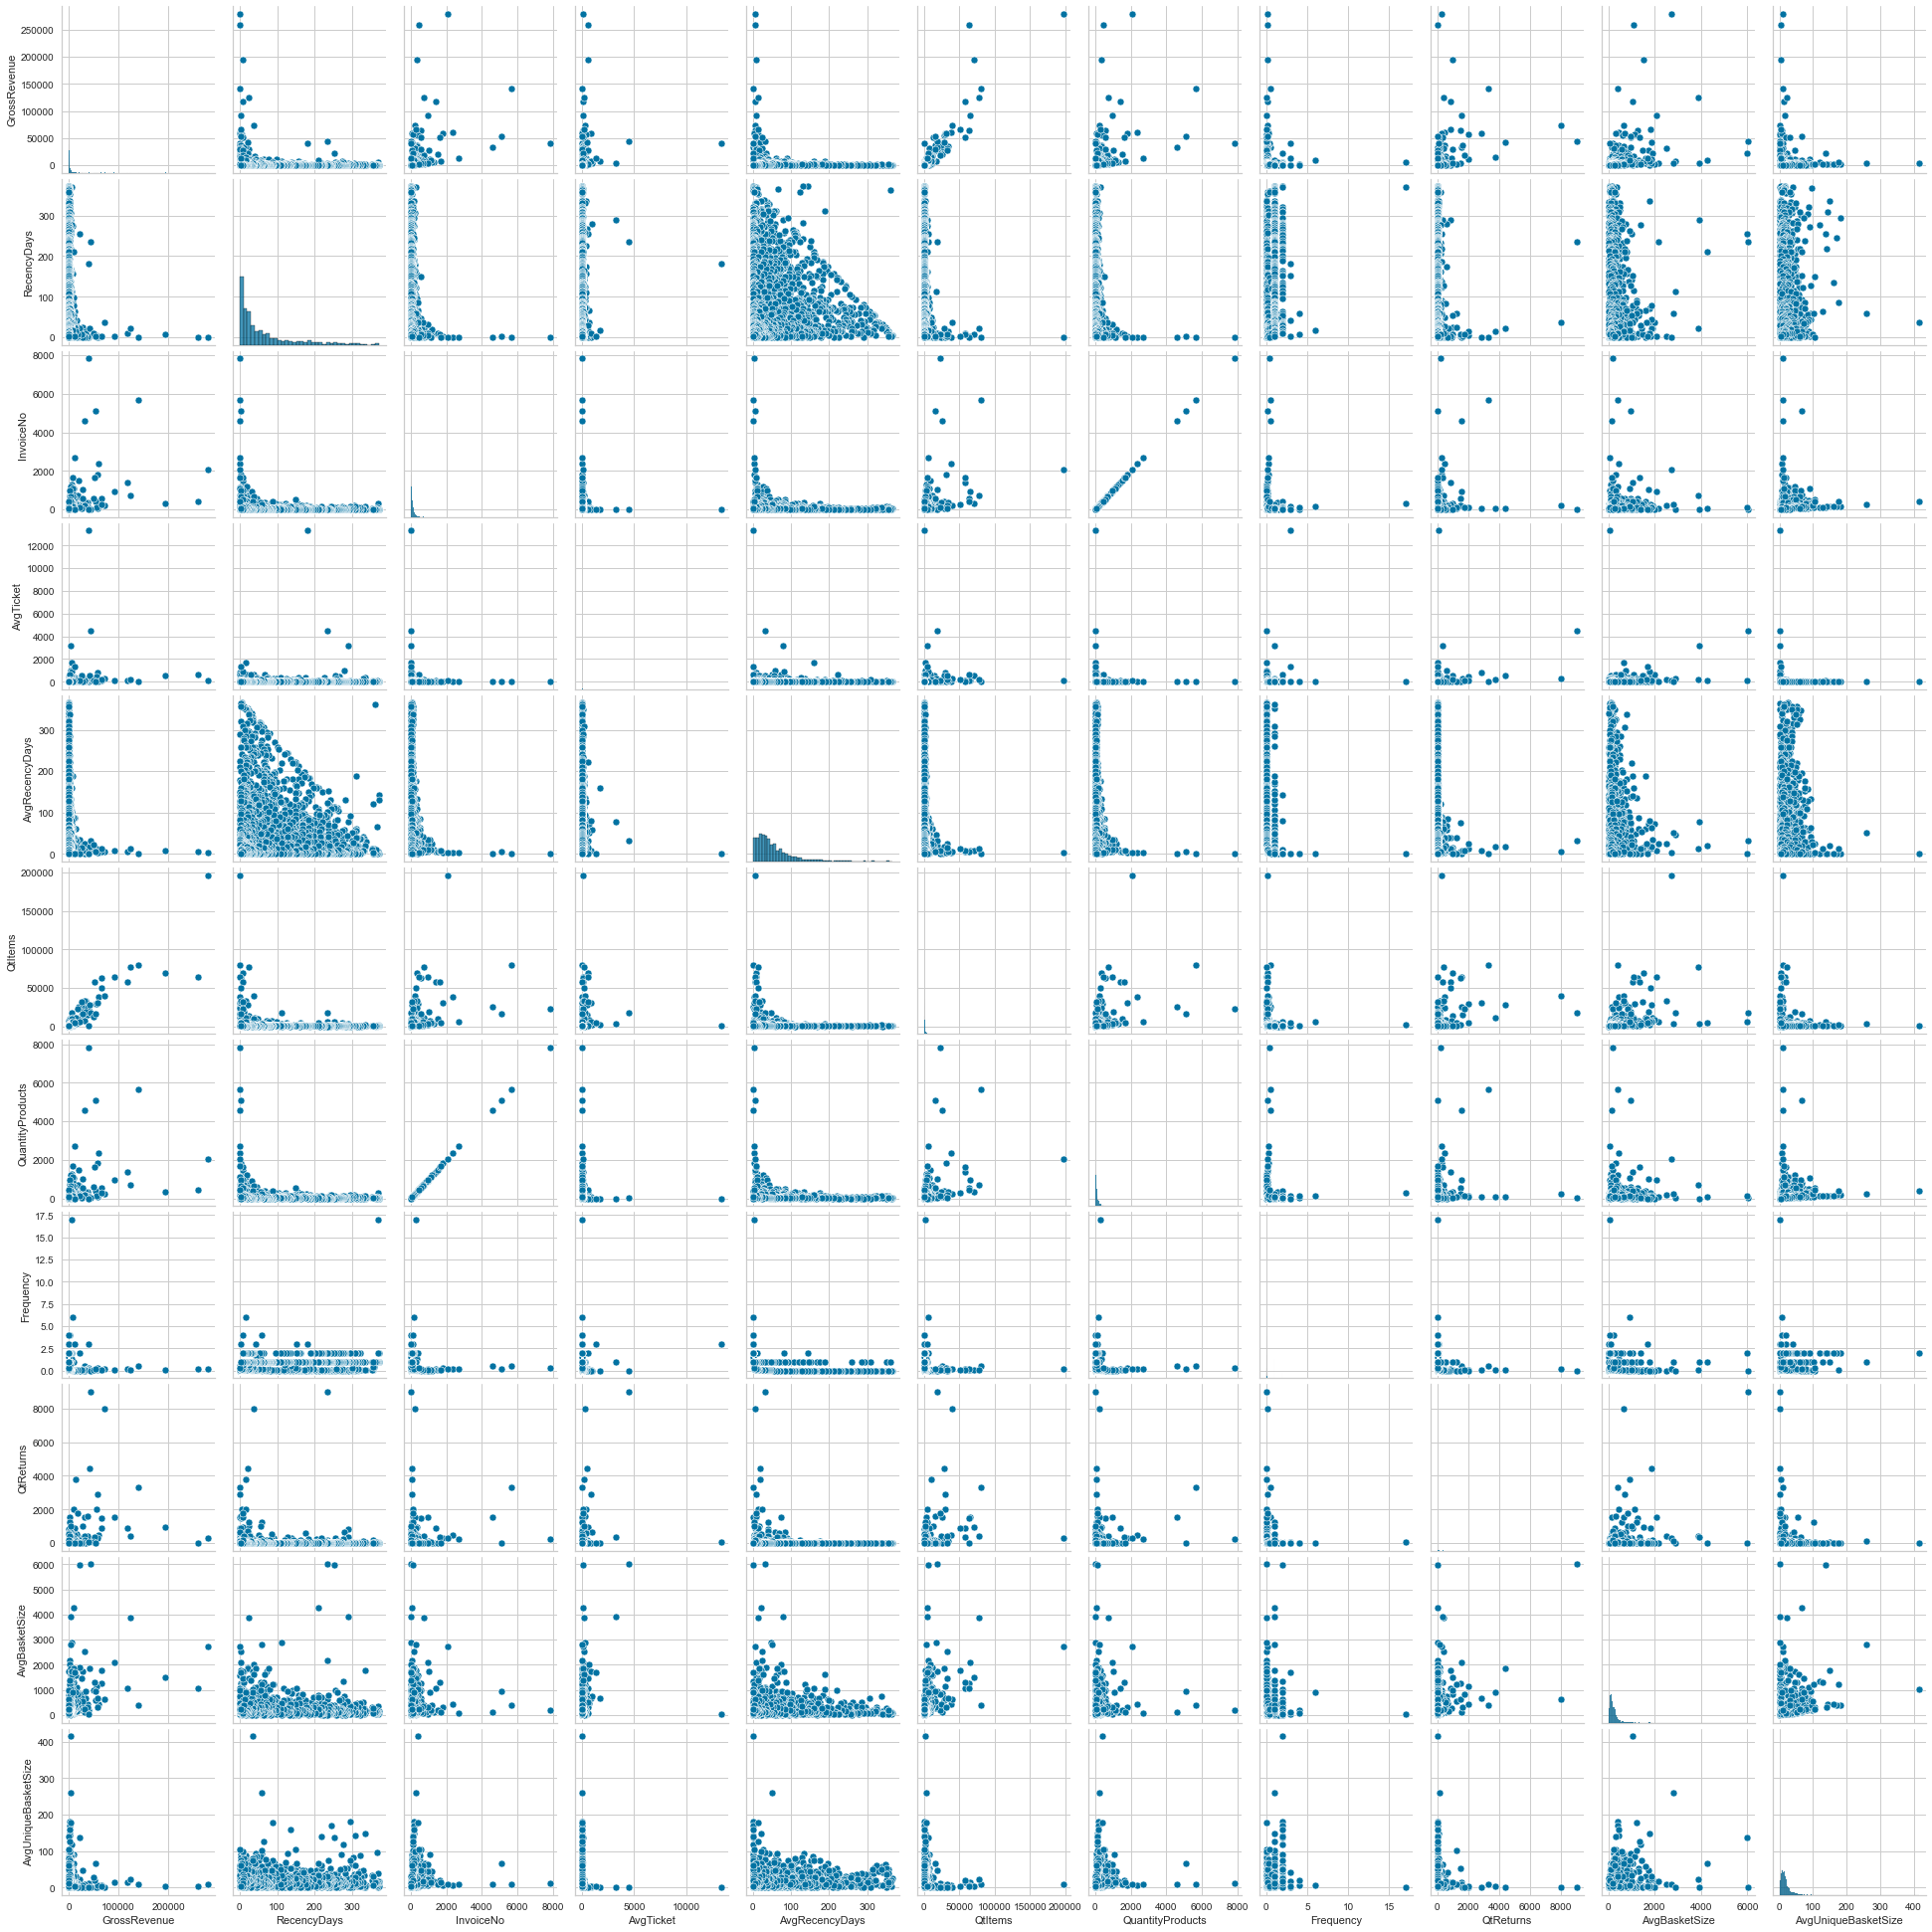

In [28]:
plt.figure(figsize=(25, 12))
sns.pairplot(df42)

## 4.3 Space Study

In [29]:
df43 = df4.drop(columns=['CustomerID'], axis=1).copy()

In [30]:
mm = pp.MinMaxScaler()

# 
df43['GrossRevenue'] = mm.fit_transform( df43[['GrossRevenue']] )
df43['RecencyDays'] = mm.fit_transform( df43[['RecencyDays']] )
df43['InvoiceNo'] = mm.fit_transform( df43[['InvoiceNo']])
df43['QtItems'] = mm.fit_transform( df43[['QtItems']])
df43['QuantityProducts'] = mm.fit_transform( df43[['QuantityProducts']])
df43['AvgTicket'] = mm.fit_transform( df43[['AvgTicket']])
df43['AvgRecencyDays'] = mm.fit_transform( df43[['AvgRecencyDays']])
df43['Frequency'] = mm.fit_transform( df43[['Frequency']])
df43['QtReturns'] = mm.fit_transform( df43[['QtReturns']])
df43['AvgBasketSize'] = mm.fit_transform( df43[['AvgBasketSize']])
df43['AvgUniqueBasketSize'] = mm.fit_transform( df43[['AvgUniqueBasketSize']])

### 4.3.1 PCA

In [31]:
df431 = df43.copy()

In [32]:
df431.shape[1]

11

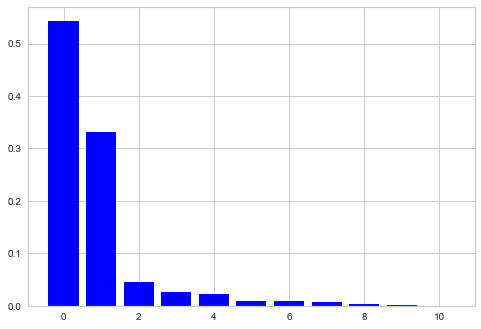

In [33]:
pca = dd.PCA(n_components=df431.shape[1])

principal_components = pca.fit_transform(df431)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='blue')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

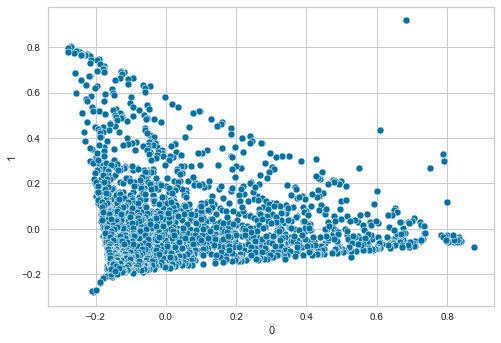

In [34]:
 sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.1 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

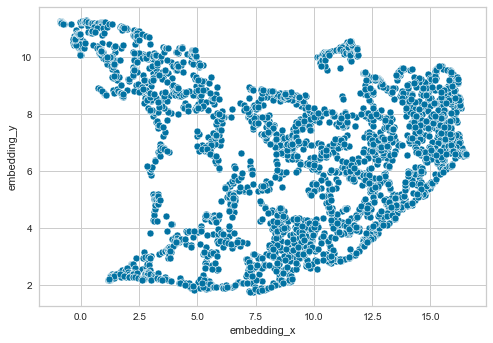

In [35]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df431)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.2 t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

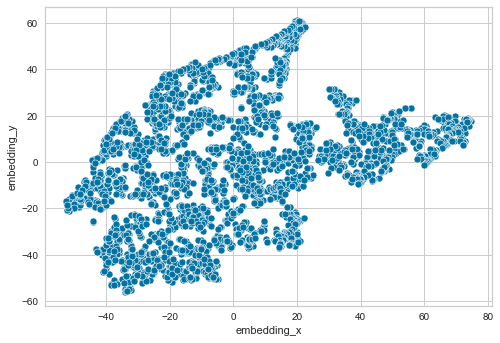

In [36]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(df431)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.3 Tree-Based Embedding

In [37]:
 # training dataset
X = df4.drop(columns=['CustomerID', 'GrossRevenue'], axis=1)
y = df4['GrossRevenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

RandomForestRegressor(random_state=42)

In [38]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [39]:
 df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2939,3236,3105,3237,2807,3256,3024,2967,2923,2852,...,2944,3169,3006,3181,3070,3030,2876,3139,3058,3214
1,2648,3160,3029,2717,2946,3241,2972,2894,3229,2805,...,2875,3142,2892,3148,3041,3225,2332,3067,3014,3235
2,3715,3637,3550,3658,3667,3704,3433,3666,3732,3691,...,3665,3654,3641,3496,3646,3690,3659,3767,3553,3704
3,1627,1535,1557,1311,1389,1403,1366,1296,1552,1457,...,1367,1994,1727,1451,1279,1621,1350,1979,1613,1525
4,602,889,480,193,203,230,188,241,827,773,...,736,586,737,218,188,205,158,730,623,227


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

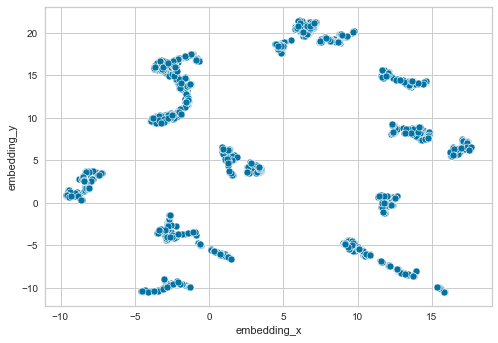

In [40]:
# Reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

# 5.0 Data Preparation

In [41]:
df5 = df4.copy()

In [42]:
df5.columns

Index(['CustomerID', 'GrossRevenue', 'RecencyDays', 'InvoiceNo', 'AvgTicket',
       'AvgRecencyDays', 'QtItems', 'QuantityProducts', 'Frequency',
       'QtReturns', 'AvgBasketSize', 'AvgUniqueBasketSize'],
      dtype='object')

In [43]:
# Standard Scalaer
#ss = pp.StandardScaler()
ss = pp.MinMaxScaler()

df5['GrossRevenue'] = ss.fit_transform(df5[['GrossRevenue']])
df5['RecencyDays'] = ss.fit_transform(df5[['RecencyDays']])
df5['InvoiceNo'] = ss.fit_transform(df5[['InvoiceNo']])
df5['AvgRecencyDays'] = ss.fit_transform(df5[['AvgRecencyDays']])
df5['QtItems'] = ss.fit_transform(df5[['QtItems']])
df5['QuantityProducts'] = ss.fit_transform(df5[['QuantityProducts']])
df5['Frequency'] = ss.fit_transform(df5[['Frequency']])
df5['QtReturns'] = ss.fit_transform(df5[['QtReturns']])
df5['AvgBasketSize'] = ss.fit_transform(df5[['AvgBasketSize']])
df5['AvgUniqueBasketSize'] = ss.fit_transform(df5[['AvgUniqueBasketSize']])

# 6.0 Feature Selection

In [44]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine Tunning

In [45]:
df7 = df6.copy()

x = df6.drop(columns=['CustomerID'])

In [46]:
x.head(5)

,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket,AvgRecencyDays,QtItems,QuantityProducts,Frequency,QtReturns,AvgBasketSize,AvgUniqueBasketSize
0,0.019292,0.997312,0.037770,18.152222,0.005729,0.008794,0.037770,1.000000,0.004438,0.008317,0.001007
1,0.011559,0.150538,0.021692,18.904035,0.062818,0.007051,0.021692,0.001344,0.003883,0.025539,0.027644
2,0.024000,0.005376,0.029476,28.902500,0.062329,0.025533,0.029476,0.002058,0.005547,0.055623,0.017840
3,0.003375,0.255376,0.003445,33.866071,0.252968,0.002220,0.003445,0.000733,0.000000,0.014447,0.011090
4,0.003116,0.895161,0.000255,292.000000,0.022466,0.000396,0.000255,0.003984,0.002441,0.004272,0.000321


In [47]:
cluster = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Square

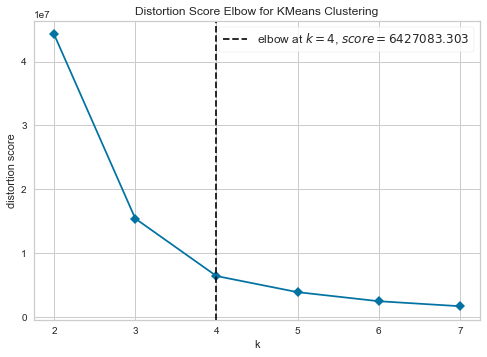

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=cluster, timings=False)
kmeans.fit(x)
kmeans.show()

## 7.2 Silhouette Score

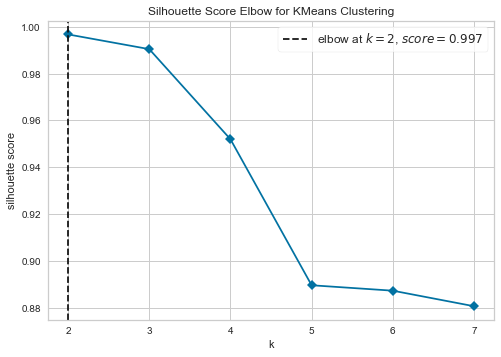

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [49]:
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=cluster, metric='silhouette', timings=False)
kmeans.fit(x)
kmeans.show()

## 7.2.1 Silhouette Analysis

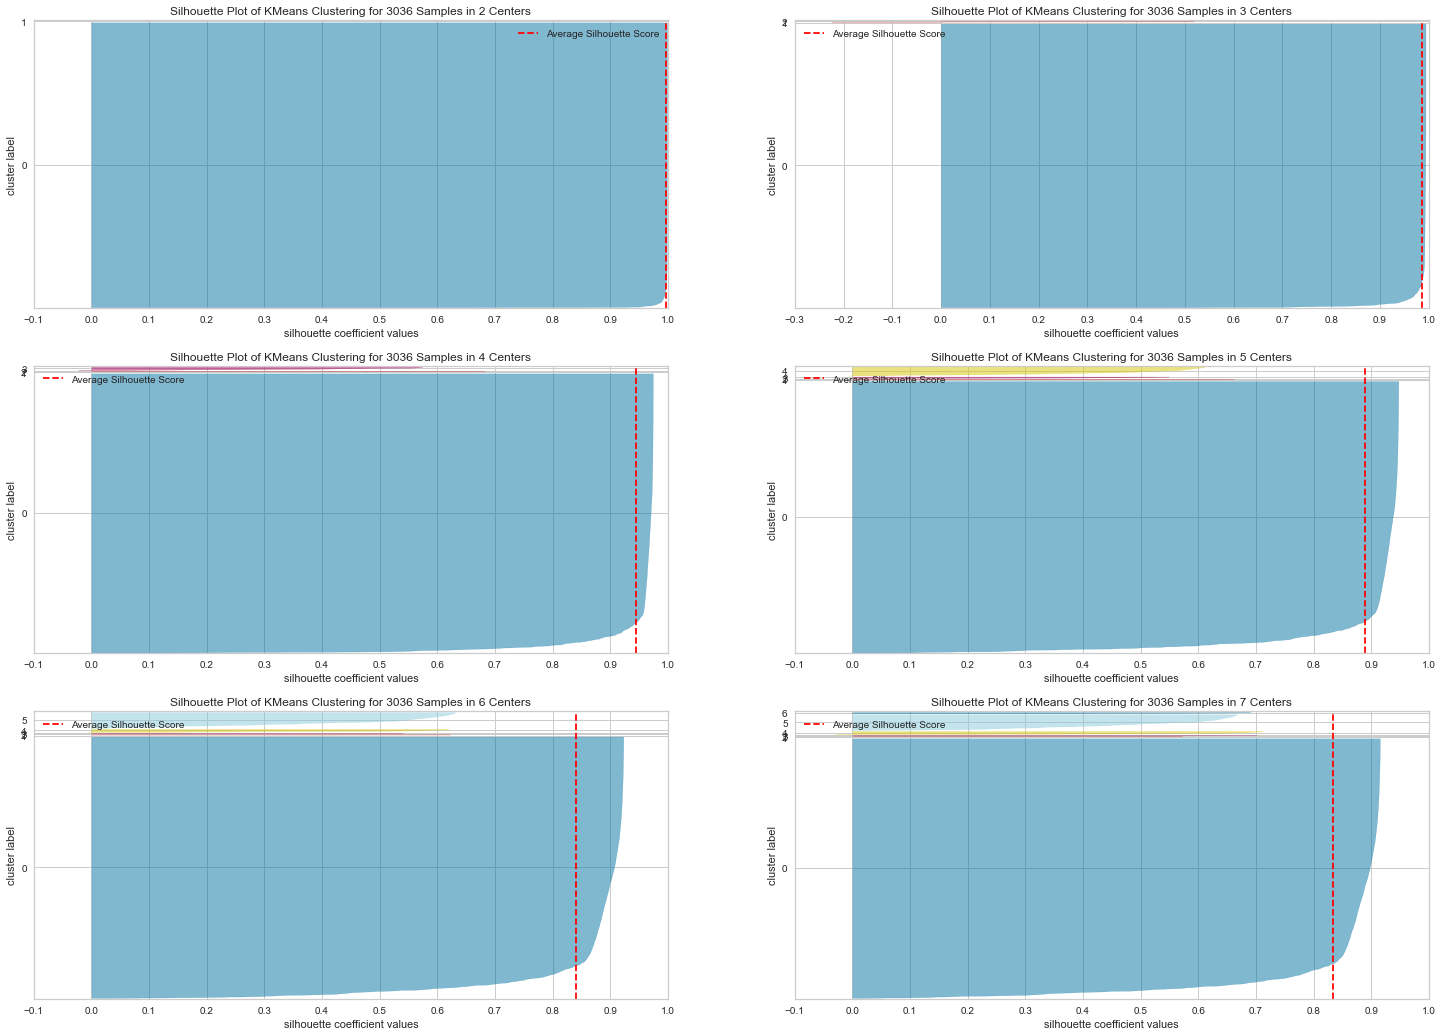

In [50]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in cluster:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    
    vz = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    vz.fit(x)
    vz.finalize()

# 8.0 Model Trainning

## 8.1 K-Means

In [61]:
k = 5
kmeansf = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

kmeansf.fit(x)

labels = kmeansf.labels_
# labels = kmeans.predict(x)

### 8.1.2 Cluster Validation

In [62]:
# WSS
print('WSS: ', kmeansf.inertia_)

# SS
print('SS: ', mt.silhouette_score(x, labels, metric='euclidean'))

WSS:  3901473.290667194
SS:  0.8896989816987237


# 9.0 Cluster Analysis

In [63]:
df9 = df6.copy()
df9['Clusters'] = labels

In [64]:
df9.head(20)

,CustomerID,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket,AvgRecencyDays,QtItems,QuantityProducts,Frequency,QtReturns,AvgBasketSize,AvgUniqueBasketSize,Clusters
0,17850,0.019292,0.997312,0.037770,18.152222,0.005729,0.008794,0.037770,1.000000,0.004438,0.008317,0.001007,0
1,13047,0.011559,0.150538,0.021692,18.904035,0.062818,0.007051,0.021692,0.001344,0.003883,0.025539,0.027644,0
2,12583,0.024000,0.005376,0.029476,28.902500,0.062329,0.025533,0.029476,0.002058,0.005547,0.055623,0.017840,0
3,13748,0.003375,0.255376,0.003445,33.866071,0.252968,0.002220,0.003445,0.000733,0.000000,0.014447,0.011090,0
4,15100,0.003116,0.895161,0.000255,292.000000,0.022466,0.000396,0.000255,0.003984,0.002441,0.004272,0.000321,4
5,15291,0.016541,0.067204,0.012888,45.326471,0.051750,0.010668,0.012888,0.002039,0.003217,0.024823,0.010022,0
6,14688,0.020151,0.018817,0.041598,17.219786,0.037619,0.018385,0.041598,0.003045,0.044264,0.028532,0.016508,0
7,17809,0.019366,0.040323,0.007656,88.719836,0.074394,0.010440,0.007656,0.001651,0.004548,0.028363,0.008759,0
8,15311,0.217681,0.000000,0.303432,25.543464,0.007493,0.194024,0.303432,0.013996,0.052585,0.069689,0.014539,0
9,16098,0.007163,0.233871,0.008422,29.934776,0.110372,0.003104,0.008422,0.001319,0.000000,0.014409,0.011227,0


## 9.1 Visualization Inspection

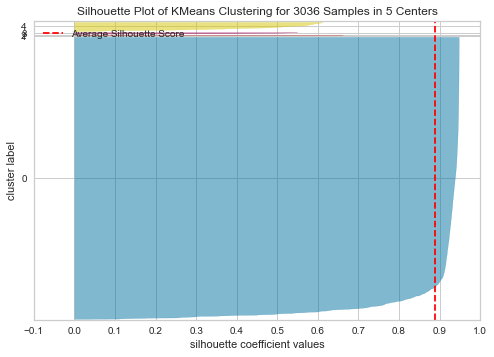

In [65]:
vz2 = SilhouetteVisualizer(kmeansf, colors='yellowbrick')
vz2.fit(x)
vz2.finalize()

## 9.2 2d Plot

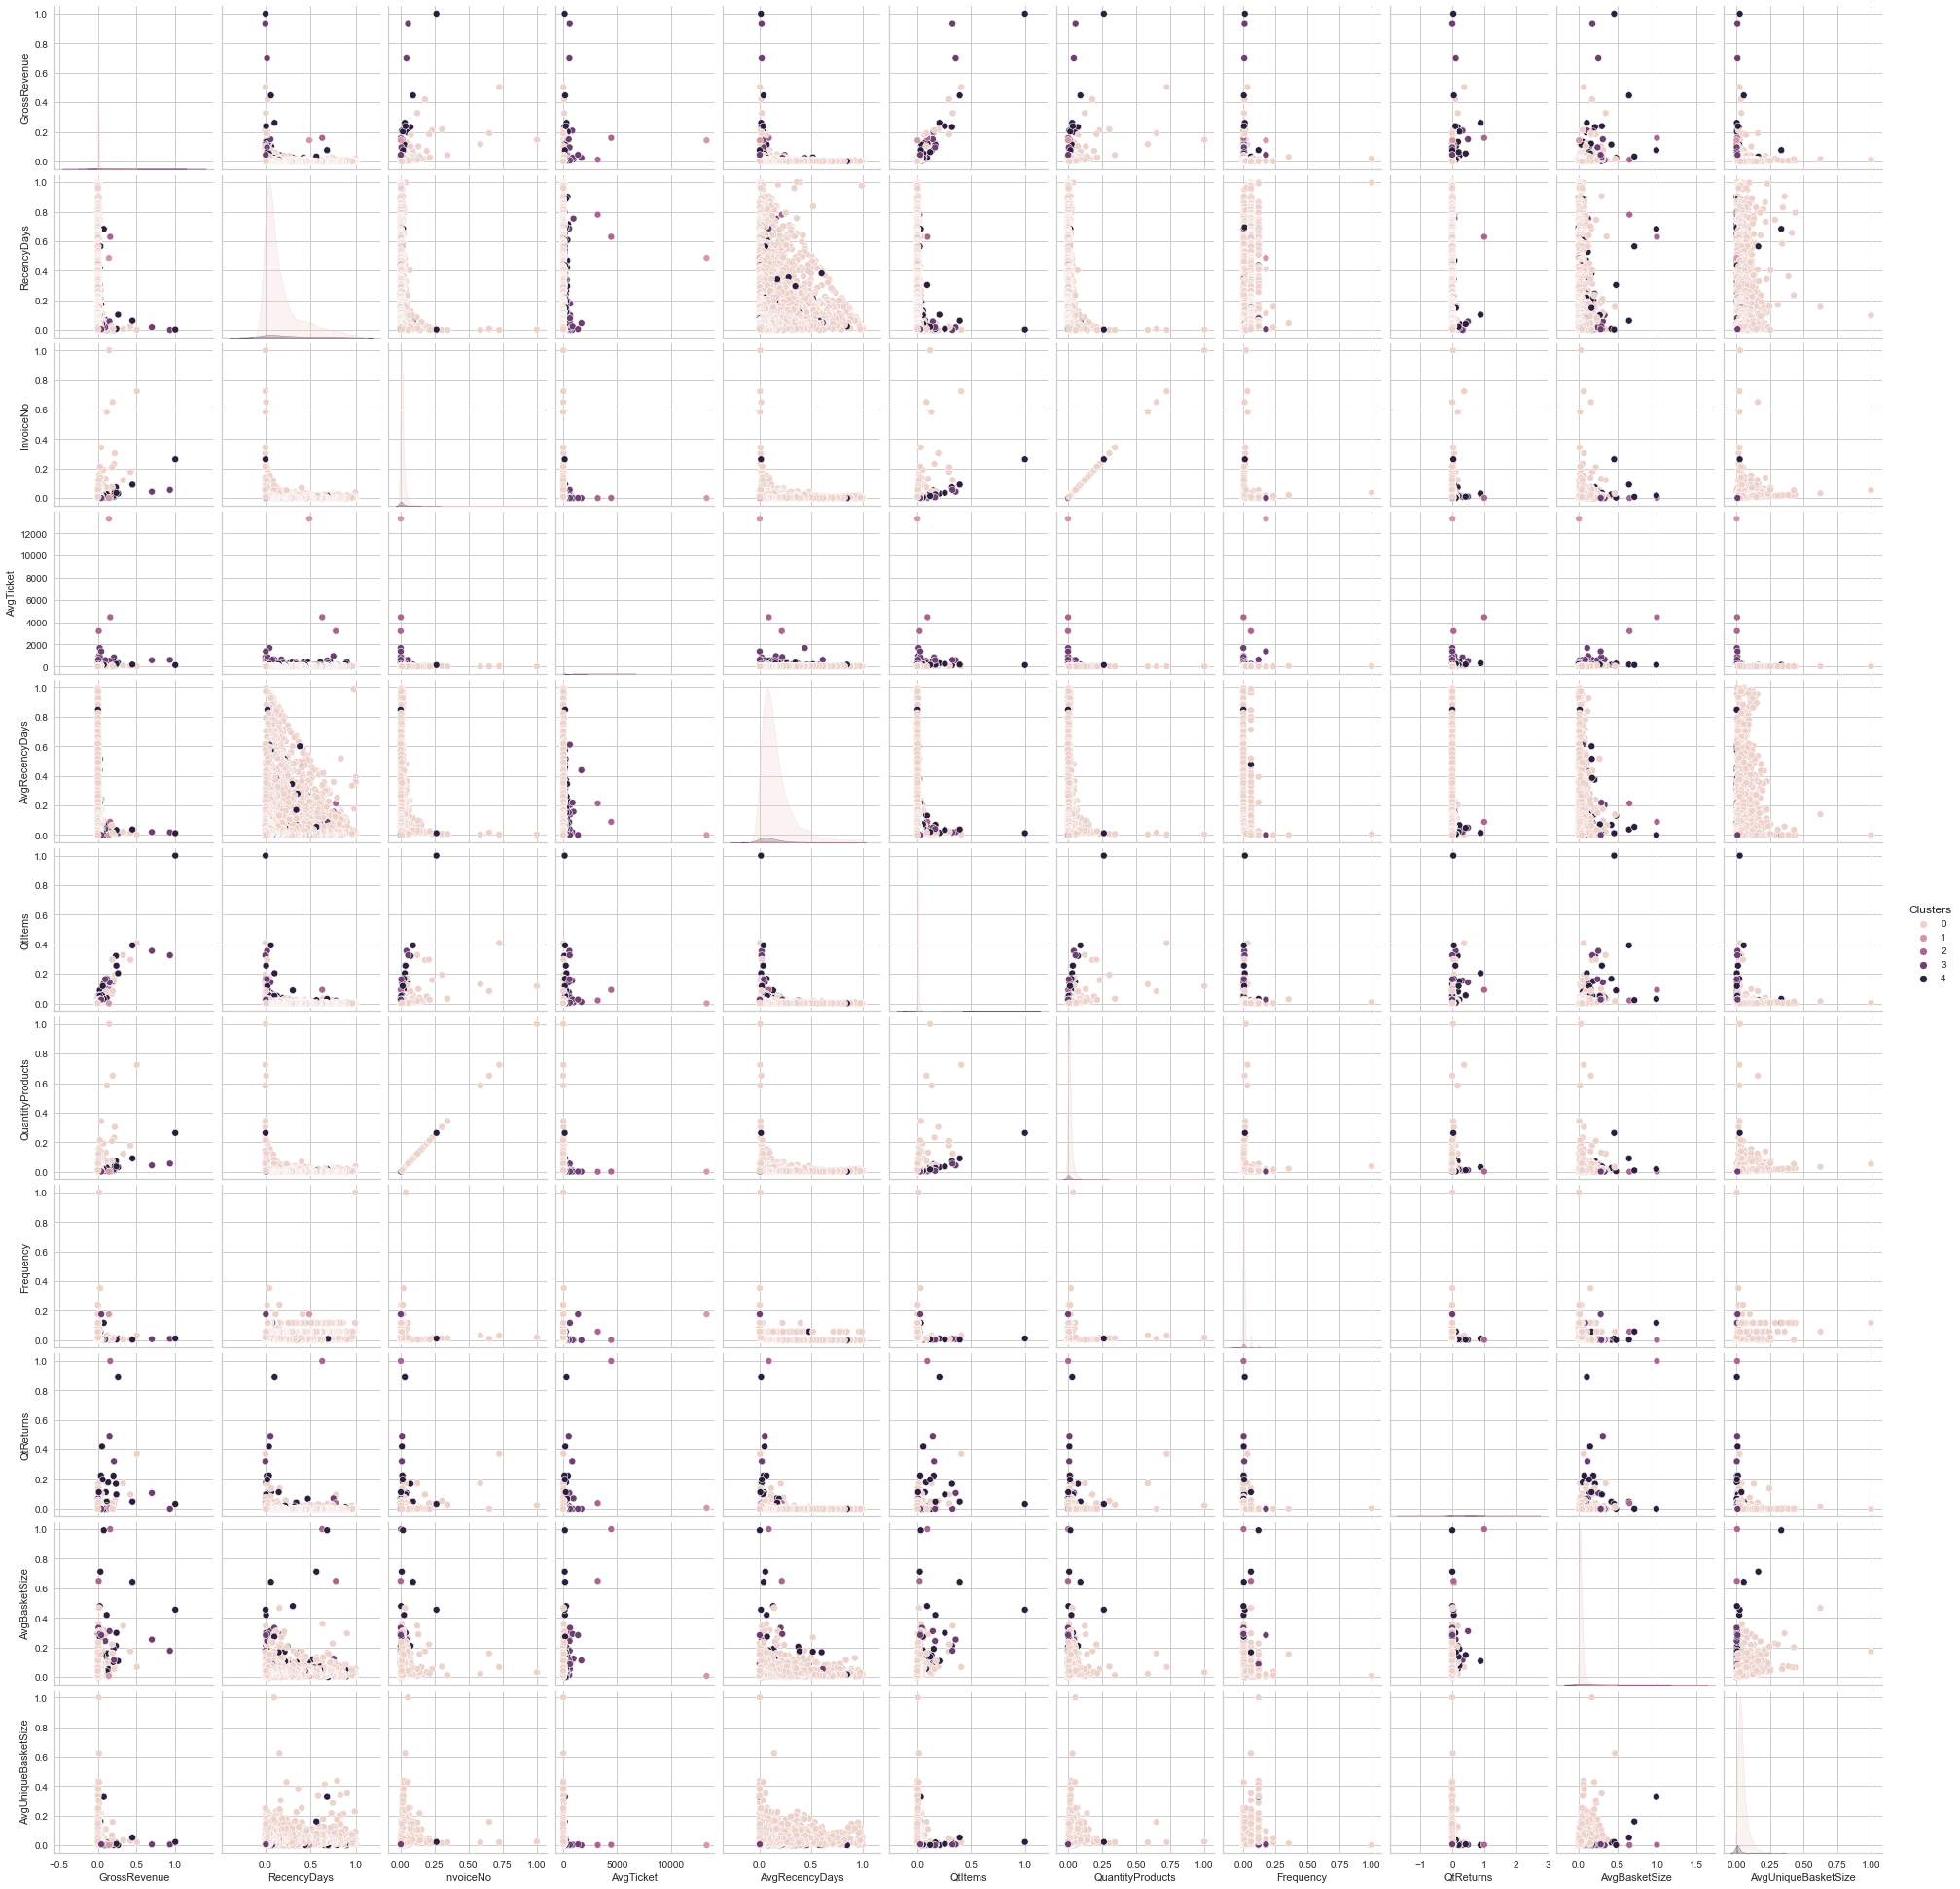

In [66]:
df_plot = df9.drop(columns='CustomerID')
sns.pairplot(df_plot, hue='Clusters')

## 9.3 UMAP 

<AxesSubplot:xlabel='EmbeddingX', ylabel='EmbeddingY'>

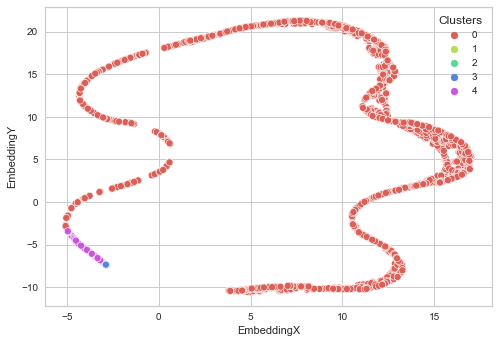

In [67]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(x)

#embedding
df_plot['EmbeddingX'] = embedding[:, 0]
df_plot['EmbeddingY'] = embedding[:, 1]

# UMAP plot
sns.scatterplot(data= df_plot, x='EmbeddingX', y='EmbeddingY', hue='Clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_plot['Clusters'].unique()))
               )

## 9.4 Cluster Profile

In [68]:
df9['GrossRevenue'] = ss.inverse_transform(df9[['GrossRevenue']])
df9['RecencyDays'] = ss.inverse_transform(df9[['RecencyDays']])
df9['InvoiceNo'] = ss.inverse_transform(df9[['InvoiceNo']])
df9['AvgTicket'] = ss.inverse_transform(df9[['AvgTicket']])

In [69]:
# clusters composition by total database 
df_cluster = df9[['CustomerID', 'Clusters']].groupby('Clusters').count().reset_index()

In [70]:
df_cluster['Pencentage'] = 100 * (df_cluster['CustomerID'] / df_cluster['CustomerID'].sum())

# Gross revenue average
avg_rev = df9[['Clusters', 'GrossRevenue']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_rev, on= 'Clusters', how='inner')

# Recency average
avg_rec = df9[['Clusters', 'RecencyDays']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_rec, on= 'Clusters', how='inner')

# InvoiceNo average
avg_in = df9[['Clusters', 'InvoiceNo']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_in, on= 'Clusters', how='inner')

# Ticket average
avg_t = df9[['Clusters', 'AvgTicket']].groupby('Clusters').mean().reset_index() 
df_cluster = pd.merge(df_cluster, avg_t, on= 'Clusters', how='inner')

df_cluster

,Clusters,CustomerID,Pencentage,GrossRevenue,RecencyDays,InvoiceNo,AvgTicket
0,0,2921,96.212121,3.306463,72.845314,6.671636,8.705136e+03
1,1,1,0.032938,59.508152,202.024731,0.305857,5.519122e+06
2,2,2,0.065876,35.660406,292.344086,0.438178,1.587927e+06
3,3,16,0.527009,60.562724,54.628562,3.653579,3.153499e+05
4,4,96,3.162055,19.530312,94.549810,4.311325,8.269415e+04
